In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import ladyns as ldn

In [5]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [6]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [7]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [8]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 10

In [9]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [10]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

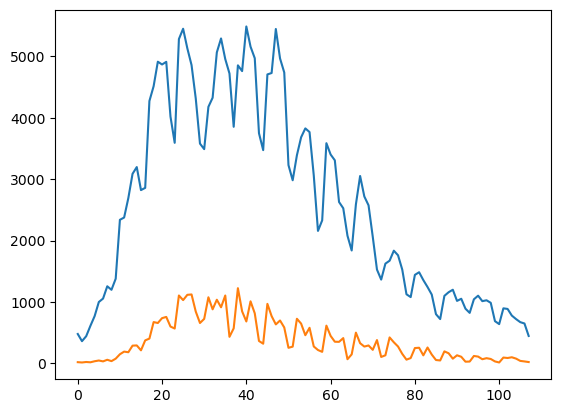

In [11]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [12]:
GPi = np.load('EuropeCovid2_GPi.npz')

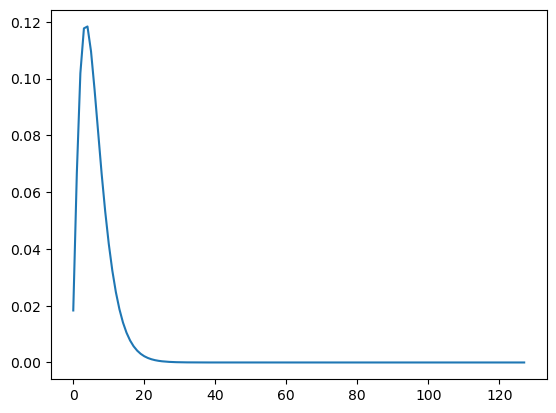

In [13]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

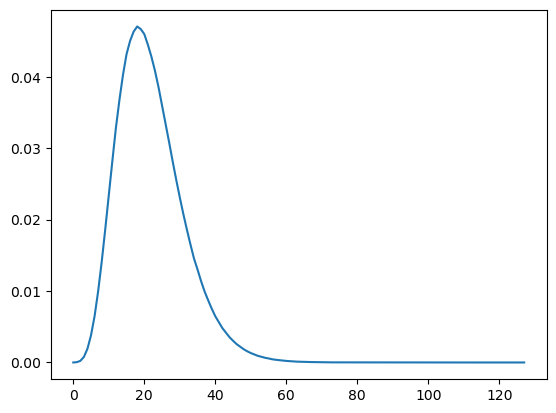

In [14]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [15]:
# A
d=2
A = np.zeros([T+T0, d])

In [16]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

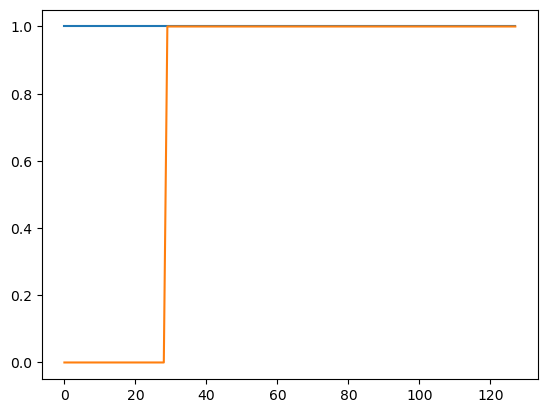

In [17]:
plt.plot(A)

# 3. fit by EM algorithm

In [18]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [53]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = [0.207, 1.872]

In [54]:
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=0.05)

Before EM, shat_eps: 395.786675
1-th iteration finished, shat_eps: 144.698952, lapse: 0.008sec.
2-th iteration finished, shat_eps: 143.532340, lapse: 0.017sec.
3-th iteration finished, shat_eps: 143.526869, lapse: 0.005sec.
4-th iteration finished, shat_eps: 143.526863, lapse: 0.007sec.
5-th iteration finished, shat_eps: 143.526858, lapse: 0.004sec.
6-th iteration finished, shat_eps: 143.526853, lapse: 0.006sec.
7-th iteration finished, shat_eps: 143.526849, lapse: 0.004sec.
8-th iteration finished, shat_eps: 143.526844, lapse: 0.004sec.
9-th iteration finished, shat_eps: 143.526839, lapse: 0.004sec.
10-th iteration finished, shat_eps: 143.526835, lapse: 0.004sec.
11-th iteration finished, shat_eps: 143.526830, lapse: 0.004sec.
12-th iteration finished, shat_eps: 143.526825, lapse: 0.004sec.
13-th iteration finished, shat_eps: 143.526821, lapse: 0.005sec.
14-th iteration finished, shat_eps: 143.526816, lapse: 0.004sec.
15-th iteration finished, shat_eps: 143.526811, lapse: 0.004sec.
16

168-th iteration finished, shat_eps: 143.526280, lapse: 0.005sec.
169-th iteration finished, shat_eps: 143.526277, lapse: 0.043sec.
170-th iteration finished, shat_eps: 143.526274, lapse: 0.017sec.
171-th iteration finished, shat_eps: 143.526272, lapse: 0.005sec.
172-th iteration finished, shat_eps: 143.526269, lapse: 0.005sec.
173-th iteration finished, shat_eps: 143.526267, lapse: 0.011sec.
174-th iteration finished, shat_eps: 143.526264, lapse: 0.005sec.
175-th iteration finished, shat_eps: 143.526262, lapse: 0.005sec.
176-th iteration finished, shat_eps: 143.526259, lapse: 0.005sec.
177-th iteration finished, shat_eps: 143.526257, lapse: 0.008sec.
178-th iteration finished, shat_eps: 143.526254, lapse: 0.005sec.
179-th iteration finished, shat_eps: 143.526252, lapse: 0.006sec.
180-th iteration finished, shat_eps: 143.526250, lapse: 0.005sec.
181-th iteration finished, shat_eps: 143.526247, lapse: 0.015sec.
182-th iteration finished, shat_eps: 143.526245, lapse: 0.006sec.
183-th ite

301-th iteration finished, shat_eps: 143.526013, lapse: 0.005sec.
302-th iteration finished, shat_eps: 143.526012, lapse: 0.005sec.
303-th iteration finished, shat_eps: 143.526010, lapse: 0.011sec.
304-th iteration finished, shat_eps: 143.526009, lapse: 0.005sec.
305-th iteration finished, shat_eps: 143.526007, lapse: 0.005sec.
306-th iteration finished, shat_eps: 143.526006, lapse: 0.005sec.
307-th iteration finished, shat_eps: 143.526004, lapse: 0.007sec.
308-th iteration finished, shat_eps: 143.526003, lapse: 0.005sec.
309-th iteration finished, shat_eps: 143.526001, lapse: 0.005sec.
310-th iteration finished, shat_eps: 143.526000, lapse: 0.006sec.
311-th iteration finished, shat_eps: 143.525998, lapse: 0.005sec.
312-th iteration finished, shat_eps: 143.525997, lapse: 0.004sec.
313-th iteration finished, shat_eps: 143.525995, lapse: 0.005sec.
314-th iteration finished, shat_eps: 143.525994, lapse: 0.007sec.
315-th iteration finished, shat_eps: 143.525992, lapse: 0.005sec.
316-th ite

433-th iteration finished, shat_eps: 143.525855, lapse: 0.005sec.
434-th iteration finished, shat_eps: 143.525854, lapse: 0.012sec.
435-th iteration finished, shat_eps: 143.525853, lapse: 0.007sec.
436-th iteration finished, shat_eps: 143.525852, lapse: 0.007sec.
437-th iteration finished, shat_eps: 143.525851, lapse: 0.005sec.
438-th iteration finished, shat_eps: 143.525850, lapse: 0.005sec.
439-th iteration finished, shat_eps: 143.525849, lapse: 0.005sec.
440-th iteration finished, shat_eps: 143.525848, lapse: 0.005sec.
441-th iteration finished, shat_eps: 143.525848, lapse: 0.007sec.
442-th iteration finished, shat_eps: 143.525847, lapse: 0.006sec.
443-th iteration finished, shat_eps: 143.525846, lapse: 0.005sec.
444-th iteration finished, shat_eps: 143.525845, lapse: 0.007sec.
445-th iteration finished, shat_eps: 143.525844, lapse: 0.004sec.
446-th iteration finished, shat_eps: 143.525843, lapse: 0.005sec.
447-th iteration finished, shat_eps: 143.525842, lapse: 0.004sec.
448-th ite

574-th iteration finished, shat_eps: 143.525755, lapse: 0.013sec.
575-th iteration finished, shat_eps: 143.525754, lapse: 0.005sec.
576-th iteration finished, shat_eps: 143.525754, lapse: 0.006sec.
577-th iteration finished, shat_eps: 143.525753, lapse: 0.005sec.
578-th iteration finished, shat_eps: 143.525753, lapse: 0.008sec.
579-th iteration finished, shat_eps: 143.525752, lapse: 0.008sec.
580-th iteration finished, shat_eps: 143.525752, lapse: 0.005sec.
581-th iteration finished, shat_eps: 143.525751, lapse: 0.004sec.
582-th iteration finished, shat_eps: 143.525751, lapse: 0.005sec.
583-th iteration finished, shat_eps: 143.525750, lapse: 0.005sec.
584-th iteration finished, shat_eps: 143.525750, lapse: 0.006sec.
585-th iteration finished, shat_eps: 143.525749, lapse: 0.006sec.
586-th iteration finished, shat_eps: 143.525749, lapse: 0.005sec.
587-th iteration finished, shat_eps: 143.525748, lapse: 0.005sec.
588-th iteration finished, shat_eps: 143.525748, lapse: 0.005sec.
589-th ite

702-th iteration finished, shat_eps: 143.525701, lapse: 0.011sec.
703-th iteration finished, shat_eps: 143.525701, lapse: 0.043sec.
704-th iteration finished, shat_eps: 143.525701, lapse: 0.004sec.
705-th iteration finished, shat_eps: 143.525700, lapse: 0.005sec.
706-th iteration finished, shat_eps: 143.525700, lapse: 0.015sec.
707-th iteration finished, shat_eps: 143.525700, lapse: 0.004sec.
708-th iteration finished, shat_eps: 143.525699, lapse: 0.005sec.
709-th iteration finished, shat_eps: 143.525699, lapse: 0.005sec.
710-th iteration finished, shat_eps: 143.525699, lapse: 0.025sec.
711-th iteration finished, shat_eps: 143.525698, lapse: 0.005sec.
712-th iteration finished, shat_eps: 143.525698, lapse: 0.004sec.
713-th iteration finished, shat_eps: 143.525698, lapse: 0.005sec.
714-th iteration finished, shat_eps: 143.525697, lapse: 0.012sec.
715-th iteration finished, shat_eps: 143.525697, lapse: 0.008sec.
716-th iteration finished, shat_eps: 143.525697, lapse: 0.005sec.
717-th ite

840-th iteration finished, shat_eps: 143.525667, lapse: 0.006sec.
841-th iteration finished, shat_eps: 143.525666, lapse: 0.014sec.
842-th iteration finished, shat_eps: 143.525666, lapse: 0.005sec.
843-th iteration finished, shat_eps: 143.525666, lapse: 0.004sec.
844-th iteration finished, shat_eps: 143.525666, lapse: 0.007sec.
845-th iteration finished, shat_eps: 143.525666, lapse: 0.006sec.
846-th iteration finished, shat_eps: 143.525666, lapse: 0.004sec.
847-th iteration finished, shat_eps: 143.525665, lapse: 0.005sec.
848-th iteration finished, shat_eps: 143.525665, lapse: 0.004sec.
849-th iteration finished, shat_eps: 143.525665, lapse: 0.004sec.
850-th iteration finished, shat_eps: 143.525665, lapse: 0.004sec.
851-th iteration finished, shat_eps: 143.525665, lapse: 0.005sec.
852-th iteration finished, shat_eps: 143.525664, lapse: 0.004sec.
853-th iteration finished, shat_eps: 143.525664, lapse: 0.005sec.
854-th iteration finished, shat_eps: 143.525664, lapse: 0.005sec.
855-th ite

974-th iteration finished, shat_eps: 143.525647, lapse: 0.015sec.
975-th iteration finished, shat_eps: 143.525647, lapse: 0.005sec.
976-th iteration finished, shat_eps: 143.525647, lapse: 0.006sec.
977-th iteration finished, shat_eps: 143.525647, lapse: 0.006sec.
978-th iteration finished, shat_eps: 143.525647, lapse: 0.004sec.
979-th iteration finished, shat_eps: 143.525646, lapse: 0.004sec.
980-th iteration finished, shat_eps: 143.525646, lapse: 0.005sec.
981-th iteration finished, shat_eps: 143.525646, lapse: 0.005sec.
982-th iteration finished, shat_eps: 143.525646, lapse: 0.012sec.
983-th iteration finished, shat_eps: 143.525646, lapse: 0.005sec.
984-th iteration finished, shat_eps: 143.525646, lapse: 0.004sec.
985-th iteration finished, shat_eps: 143.525646, lapse: 0.005sec.
986-th iteration finished, shat_eps: 143.525646, lapse: 0.005sec.
987-th iteration finished, shat_eps: 143.525646, lapse: 0.005sec.
988-th iteration finished, shat_eps: 143.525645, lapse: 0.005sec.
989-th ite

1132-th iteration finished, shat_eps: 143.525634, lapse: 0.033sec.
1133-th iteration finished, shat_eps: 143.525634, lapse: 0.018sec.
1134-th iteration finished, shat_eps: 143.525634, lapse: 0.007sec.
1135-th iteration finished, shat_eps: 143.525634, lapse: 0.017sec.
1136-th iteration finished, shat_eps: 143.525634, lapse: 0.005sec.
1137-th iteration finished, shat_eps: 143.525633, lapse: 0.005sec.
1138-th iteration finished, shat_eps: 143.525633, lapse: 0.005sec.
1139-th iteration finished, shat_eps: 143.525633, lapse: 0.010sec.
1140-th iteration finished, shat_eps: 143.525633, lapse: 0.005sec.
1141-th iteration finished, shat_eps: 143.525633, lapse: 0.007sec.
1142-th iteration finished, shat_eps: 143.525633, lapse: 0.005sec.
1143-th iteration finished, shat_eps: 143.525633, lapse: 0.006sec.
1144-th iteration finished, shat_eps: 143.525633, lapse: 0.006sec.
1145-th iteration finished, shat_eps: 143.525633, lapse: 0.006sec.
1146-th iteration finished, shat_eps: 143.525633, lapse: 0.011

1290-th iteration finished, shat_eps: 143.525627, lapse: 0.009sec.
1291-th iteration finished, shat_eps: 143.525627, lapse: 0.009sec.
1292-th iteration finished, shat_eps: 143.525627, lapse: 0.005sec.
1293-th iteration finished, shat_eps: 143.525627, lapse: 0.004sec.
1294-th iteration finished, shat_eps: 143.525627, lapse: 0.004sec.
1295-th iteration finished, shat_eps: 143.525627, lapse: 0.004sec.
1296-th iteration finished, shat_eps: 143.525626, lapse: 0.004sec.
1297-th iteration finished, shat_eps: 143.525626, lapse: 0.004sec.
1298-th iteration finished, shat_eps: 143.525626, lapse: 0.004sec.
1299-th iteration finished, shat_eps: 143.525626, lapse: 0.010sec.
1300-th iteration finished, shat_eps: 143.525626, lapse: 0.005sec.
1301-th iteration finished, shat_eps: 143.525626, lapse: 0.005sec.
1302-th iteration finished, shat_eps: 143.525626, lapse: 0.005sec.
1303-th iteration finished, shat_eps: 143.525626, lapse: 0.004sec.
1304-th iteration finished, shat_eps: 143.525626, lapse: 0.005

1440-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1441-th iteration finished, shat_eps: 143.525623, lapse: 0.013sec.
1442-th iteration finished, shat_eps: 143.525623, lapse: 0.004sec.
1443-th iteration finished, shat_eps: 143.525623, lapse: 0.004sec.
1444-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1445-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1446-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1447-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1448-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1449-th iteration finished, shat_eps: 143.525623, lapse: 0.004sec.
1450-th iteration finished, shat_eps: 143.525623, lapse: 0.012sec.
1451-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1452-th iteration finished, shat_eps: 143.525623, lapse: 0.006sec.
1453-th iteration finished, shat_eps: 143.525623, lapse: 0.005sec.
1454-th iteration finished, shat_eps: 143.525623, lapse: 0.005

1563-th iteration finished, shat_eps: 143.525621, lapse: 0.009sec.
1564-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1565-th iteration finished, shat_eps: 143.525621, lapse: 0.004sec.
1566-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1567-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1568-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1569-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1570-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1571-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1572-th iteration finished, shat_eps: 143.525621, lapse: 0.004sec.
1573-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1574-th iteration finished, shat_eps: 143.525621, lapse: 0.004sec.
1575-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1576-th iteration finished, shat_eps: 143.525621, lapse: 0.005sec.
1577-th iteration finished, shat_eps: 143.525621, lapse: 0.005

1691-th iteration finished, shat_eps: 143.525620, lapse: 0.005sec.
1692-th iteration finished, shat_eps: 143.525620, lapse: 0.005sec.
1693-th iteration finished, shat_eps: 143.525620, lapse: 0.006sec.
1694-th iteration finished, shat_eps: 143.525620, lapse: 0.010sec.
1695-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1696-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1697-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1698-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1699-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1700-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1701-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1702-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1703-th iteration finished, shat_eps: 143.525620, lapse: 0.004sec.
1704-th iteration finished, shat_eps: 143.525620, lapse: 0.005sec.
1705-th iteration finished, shat_eps: 143.525620, lapse: 0.004

1846-th iteration finished, shat_eps: 143.525619, lapse: 0.011sec.
1847-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
1848-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
1849-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
1850-th iteration finished, shat_eps: 143.525619, lapse: 0.007sec.
1851-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
1852-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1853-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1854-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1855-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
1856-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1857-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1858-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1859-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
1860-th iteration finished, shat_eps: 143.525619, lapse: 0.006

2012-th iteration finished, shat_eps: 143.525619, lapse: 0.011sec.
2013-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2014-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2015-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2016-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2017-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2018-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2019-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2020-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2021-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2022-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2023-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2024-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2025-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2026-th iteration finished, shat_eps: 143.525619, lapse: 0.005

2140-th iteration finished, shat_eps: 143.525619, lapse: 0.010sec.
2141-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2142-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2143-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2144-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2145-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2146-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2147-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2148-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2149-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2150-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2151-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2152-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2153-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2154-th iteration finished, shat_eps: 143.525619, lapse: 0.005

2264-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2265-th iteration finished, shat_eps: 143.525619, lapse: 0.011sec.
2266-th iteration finished, shat_eps: 143.525619, lapse: 0.008sec.
2267-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2268-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2269-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2270-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2271-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2272-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2273-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2274-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2275-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2276-th iteration finished, shat_eps: 143.525619, lapse: 0.005sec.
2277-th iteration finished, shat_eps: 143.525619, lapse: 0.004sec.
2278-th iteration finished, shat_eps: 143.525619, lapse: 0.004

2392-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2393-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
2394-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2395-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2396-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2397-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2398-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2399-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2400-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2401-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2402-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2403-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
2404-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2405-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2406-th iteration finished, shat_eps: 143.525618, lapse: 0.004

2517-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2518-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
2519-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2520-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2521-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2522-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2523-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2524-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2525-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2526-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2527-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2528-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2529-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2530-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2531-th iteration finished, shat_eps: 143.525618, lapse: 0.005

2647-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2648-th iteration finished, shat_eps: 143.525618, lapse: 0.015sec.
2649-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2650-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2651-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
2652-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2653-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2654-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2655-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2656-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
2657-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2658-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2659-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2660-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2661-th iteration finished, shat_eps: 143.525618, lapse: 0.005

2772-th iteration finished, shat_eps: 143.525618, lapse: 0.013sec.
2773-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2774-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2775-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2776-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2777-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
2778-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2779-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2780-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2781-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
2782-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
2783-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2784-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2785-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2786-th iteration finished, shat_eps: 143.525618, lapse: 0.006

2897-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
2898-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2899-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2900-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
2901-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2902-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2903-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2904-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2905-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2906-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2907-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2908-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
2909-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2910-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
2911-th iteration finished, shat_eps: 143.525618, lapse: 0.004

3020-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3021-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
3022-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3023-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3024-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3025-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3026-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3027-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3028-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3029-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3030-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3031-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3032-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3033-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3034-th iteration finished, shat_eps: 143.525618, lapse: 0.005

3180-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3181-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
3182-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3183-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
3184-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3185-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3186-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3187-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3188-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3189-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3190-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3191-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3192-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3193-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3194-th iteration finished, shat_eps: 143.525618, lapse: 0.004

3306-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3307-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
3308-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3309-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3310-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3311-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3312-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3313-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3314-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3315-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3316-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3317-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3318-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3319-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3320-th iteration finished, shat_eps: 143.525618, lapse: 0.007

3430-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3431-th iteration finished, shat_eps: 143.525618, lapse: 0.013sec.
3432-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3433-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3434-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
3435-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3436-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3437-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3438-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
3439-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3440-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3441-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
3442-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3443-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3444-th iteration finished, shat_eps: 143.525618, lapse: 0.005

3558-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3559-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3560-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
3561-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
3562-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3563-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3564-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3565-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3566-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3567-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3568-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3569-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3570-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3571-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3572-th iteration finished, shat_eps: 143.525618, lapse: 0.005

3684-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3685-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
3686-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3687-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3688-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3689-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3690-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3691-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3692-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3693-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3694-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3695-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3696-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3697-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3698-th iteration finished, shat_eps: 143.525618, lapse: 0.004

3808-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3809-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3810-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3811-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3812-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3813-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3814-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3815-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3816-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3817-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3818-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3819-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
3820-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3821-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3822-th iteration finished, shat_eps: 143.525618, lapse: 0.004

3935-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
3936-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3937-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3938-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
3939-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3940-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3941-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3942-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3943-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3944-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3945-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
3946-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
3947-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
3948-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
3949-th iteration finished, shat_eps: 143.525618, lapse: 0.004

4060-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4061-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4062-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4063-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
4064-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4065-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4066-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4067-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4068-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4069-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4070-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4071-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
4072-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
4073-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
4074-th iteration finished, shat_eps: 143.525618, lapse: 0.005

4190-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
4191-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
4192-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4193-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4194-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4195-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4196-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4197-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4198-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4199-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4200-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4201-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4202-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4203-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4204-th iteration finished, shat_eps: 143.525618, lapse: 0.008

4319-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
4320-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4321-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4322-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4323-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4324-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4325-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4326-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4327-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4328-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4329-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4330-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4331-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4332-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4333-th iteration finished, shat_eps: 143.525618, lapse: 0.005

4445-th iteration finished, shat_eps: 143.525618, lapse: 0.014sec.
4446-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4447-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4448-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4449-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4450-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4451-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4452-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4453-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4454-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4455-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4456-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
4457-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4458-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4459-th iteration finished, shat_eps: 143.525618, lapse: 0.005

4576-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
4577-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
4578-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4579-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4580-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4581-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4582-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4583-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
4584-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4585-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4586-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4587-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4588-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4589-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4590-th iteration finished, shat_eps: 143.525618, lapse: 0.005

4701-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
4702-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
4703-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4704-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4705-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4706-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4707-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4708-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4709-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4710-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4711-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4712-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4713-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
4714-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
4715-th iteration finished, shat_eps: 143.525618, lapse: 0.006

4858-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
4859-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4860-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4861-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4862-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4863-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4864-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4865-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4866-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4867-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
4868-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4869-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4870-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
4871-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4872-th iteration finished, shat_eps: 143.525618, lapse: 0.006

4982-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4983-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
4984-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4985-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4986-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4987-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4988-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4989-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4990-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4991-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4992-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4993-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4994-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
4995-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
4996-th iteration finished, shat_eps: 143.525618, lapse: 0.005

5138-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
5139-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
5140-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5141-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5142-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5143-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5144-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5145-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
5146-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5147-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5148-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5149-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5150-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5151-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5152-th iteration finished, shat_eps: 143.525618, lapse: 0.005

5272-th iteration finished, shat_eps: 143.525618, lapse: 0.020sec.
5273-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5274-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
5275-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5276-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5277-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5278-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5279-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5280-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5281-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5282-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
5283-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5284-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
5285-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5286-th iteration finished, shat_eps: 143.525618, lapse: 0.005

5424-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5425-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
5426-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5427-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5428-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5429-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5430-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5431-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5432-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5433-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5434-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5435-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5436-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5437-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5438-th iteration finished, shat_eps: 143.525618, lapse: 0.004

5569-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
5570-th iteration finished, shat_eps: 143.525618, lapse: 0.014sec.
5571-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5572-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5573-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5574-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5575-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5576-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5577-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5578-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5579-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5580-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
5581-th iteration finished, shat_eps: 143.525618, lapse: 0.013sec.
5582-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
5583-th iteration finished, shat_eps: 143.525618, lapse: 0.004

5726-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5727-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
5728-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5729-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5730-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5731-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5732-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5733-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5734-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
5735-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5736-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5737-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5738-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5739-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5740-th iteration finished, shat_eps: 143.525618, lapse: 0.005

5849-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
5850-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
5851-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5852-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5853-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
5854-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5855-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5856-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5857-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5858-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5859-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5860-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5861-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5862-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5863-th iteration finished, shat_eps: 143.525618, lapse: 0.006

5973-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
5974-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
5975-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5976-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5977-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5978-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5979-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5980-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5981-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
5982-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5983-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
5984-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5985-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
5986-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
5987-th iteration finished, shat_eps: 143.525618, lapse: 0.004

6103-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6104-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6105-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6106-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
6107-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6108-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6109-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6110-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6111-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6112-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6113-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
6114-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6115-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6116-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
6117-th iteration finished, shat_eps: 143.525618, lapse: 0.004

6226-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6227-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
6228-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6229-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6230-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6231-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6232-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
6233-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6234-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6235-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6236-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6237-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
6238-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6239-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6240-th iteration finished, shat_eps: 143.525618, lapse: 0.005

6390-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
6391-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6392-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6393-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6394-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6395-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6396-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6397-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6398-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6399-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6400-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6401-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6402-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6403-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6404-th iteration finished, shat_eps: 143.525618, lapse: 0.007

6519-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
6520-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
6521-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6522-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6523-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6524-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6525-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6526-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6527-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6528-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6529-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6530-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6531-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6532-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6533-th iteration finished, shat_eps: 143.525618, lapse: 0.004

6683-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6684-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
6685-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6686-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6687-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6688-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6689-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6690-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6691-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6692-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6693-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6694-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6695-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6696-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6697-th iteration finished, shat_eps: 143.525618, lapse: 0.005

6810-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
6811-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6812-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6813-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6814-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6815-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
6816-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
6817-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6818-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6819-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6820-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6821-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6822-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6823-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6824-th iteration finished, shat_eps: 143.525618, lapse: 0.004

6939-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6940-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
6941-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6942-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6943-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6944-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6945-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6946-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6947-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6948-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
6949-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6950-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6951-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
6952-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
6953-th iteration finished, shat_eps: 143.525618, lapse: 0.005

7101-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7102-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
7103-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7104-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7105-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7106-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7107-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7108-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7109-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7110-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7111-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7112-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
7113-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7114-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7115-th iteration finished, shat_eps: 143.525618, lapse: 0.005

7226-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
7227-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7228-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7229-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7230-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7231-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7232-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
7233-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7234-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7235-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7236-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7237-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7238-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7239-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7240-th iteration finished, shat_eps: 143.525618, lapse: 0.005

7352-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7353-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7354-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7355-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7356-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7357-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7358-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7359-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7360-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7361-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7362-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7363-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
7364-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7365-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7366-th iteration finished, shat_eps: 143.525618, lapse: 0.005

7484-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
7485-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7486-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7487-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7488-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7489-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7490-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7491-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7492-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7493-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7494-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7495-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7496-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7497-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
7498-th iteration finished, shat_eps: 143.525618, lapse: 0.005

7613-th iteration finished, shat_eps: 143.525618, lapse: 0.014sec.
7614-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
7615-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7616-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7617-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7618-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7619-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7620-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7621-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7622-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7623-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7624-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7625-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7626-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7627-th iteration finished, shat_eps: 143.525618, lapse: 0.004

7738-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7739-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7740-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
7741-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7742-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
7743-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7744-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7745-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7746-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7747-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7748-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7749-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7750-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7751-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7752-th iteration finished, shat_eps: 143.525618, lapse: 0.004

7866-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7867-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
7868-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7869-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7870-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7871-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7872-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7873-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7874-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7875-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7876-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7877-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7878-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7879-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7880-th iteration finished, shat_eps: 143.525618, lapse: 0.005

7991-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
7992-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
7993-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
7994-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7995-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7996-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7997-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7998-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
7999-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8000-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8001-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8002-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8003-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8004-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8005-th iteration finished, shat_eps: 143.525618, lapse: 0.005

8123-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8124-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
8125-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8126-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8127-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8128-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8129-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8130-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8131-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8132-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8133-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8134-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8135-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8136-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8137-th iteration finished, shat_eps: 143.525618, lapse: 0.004

8289-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8290-th iteration finished, shat_eps: 143.525618, lapse: 0.012sec.
8291-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8292-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8293-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8294-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8295-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8296-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8297-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8298-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8299-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8300-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8301-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
8302-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8303-th iteration finished, shat_eps: 143.525618, lapse: 0.005

8438-th iteration finished, shat_eps: 143.525618, lapse: 0.058sec.
8439-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
8440-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8441-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8442-th iteration finished, shat_eps: 143.525618, lapse: 0.016sec.
8443-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
8444-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8445-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8446-th iteration finished, shat_eps: 143.525618, lapse: 0.053sec.
8447-th iteration finished, shat_eps: 143.525618, lapse: 0.081sec.
8448-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
8449-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8450-th iteration finished, shat_eps: 143.525618, lapse: 0.014sec.
8451-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
8452-th iteration finished, shat_eps: 143.525618, lapse: 0.005

8606-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8607-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8608-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
8609-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8610-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8611-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8612-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8613-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8614-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8615-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8616-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8617-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8618-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8619-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8620-th iteration finished, shat_eps: 143.525618, lapse: 0.006

8733-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8734-th iteration finished, shat_eps: 143.525618, lapse: 0.013sec.
8735-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8736-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8737-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8738-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
8739-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8740-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8741-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8742-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8743-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8744-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8745-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8746-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8747-th iteration finished, shat_eps: 143.525618, lapse: 0.004

8895-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
8896-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8897-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8898-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8899-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8900-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8901-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8902-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8903-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
8904-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8905-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8906-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
8907-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
8908-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
8909-th iteration finished, shat_eps: 143.525618, lapse: 0.005

9060-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9061-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9062-th iteration finished, shat_eps: 143.525618, lapse: 0.010sec.
9063-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9064-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9065-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9066-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9067-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9068-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9069-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9070-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9071-th iteration finished, shat_eps: 143.525618, lapse: 0.009sec.
9072-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9073-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9074-th iteration finished, shat_eps: 143.525618, lapse: 0.011

9223-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9224-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9225-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9226-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
9227-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
9228-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9229-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9230-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9231-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9232-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9233-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9234-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9235-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9236-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9237-th iteration finished, shat_eps: 143.525618, lapse: 0.008

9355-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9356-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
9357-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9358-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9359-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9360-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9361-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9362-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9363-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9364-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9365-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9366-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9367-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9368-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9369-th iteration finished, shat_eps: 143.525618, lapse: 0.005

9479-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9480-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9481-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
9482-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9483-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9484-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9485-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
9486-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9487-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9488-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9489-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9490-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9491-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9492-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9493-th iteration finished, shat_eps: 143.525618, lapse: 0.005

9607-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9608-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9609-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9610-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9611-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9612-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9613-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9614-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9615-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9616-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9617-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9618-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9619-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9620-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9621-th iteration finished, shat_eps: 143.525618, lapse: 0.005

9754-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9755-th iteration finished, shat_eps: 143.525618, lapse: 0.014sec.
9756-th iteration finished, shat_eps: 143.525618, lapse: 0.006sec.
9757-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9758-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9759-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9760-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
9761-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9762-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9763-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9764-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9765-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9766-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9767-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9768-th iteration finished, shat_eps: 143.525618, lapse: 0.005

9877-th iteration finished, shat_eps: 143.525618, lapse: 0.011sec.
9878-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9879-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9880-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9881-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9882-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9883-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9884-th iteration finished, shat_eps: 143.525618, lapse: 0.004sec.
9885-th iteration finished, shat_eps: 143.525618, lapse: 0.008sec.
9886-th iteration finished, shat_eps: 143.525618, lapse: 0.007sec.
9887-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9888-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9889-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9890-th iteration finished, shat_eps: 143.525618, lapse: 0.005sec.
9891-th iteration finished, shat_eps: 143.525618, lapse: 0.005

In [55]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [56]:
mmle_0, smle_eps, bmle

(77.5553241141002, 143.52561838810527, array([0.21677653, 1.86110537]))

## plots

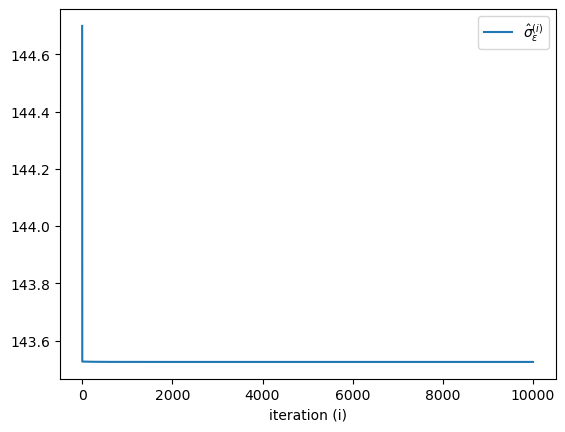

In [57]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
plt.xlabel("iteration (i)"); plt.legend()

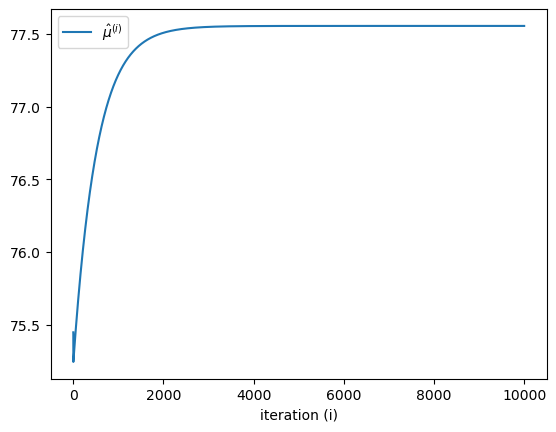

In [58]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

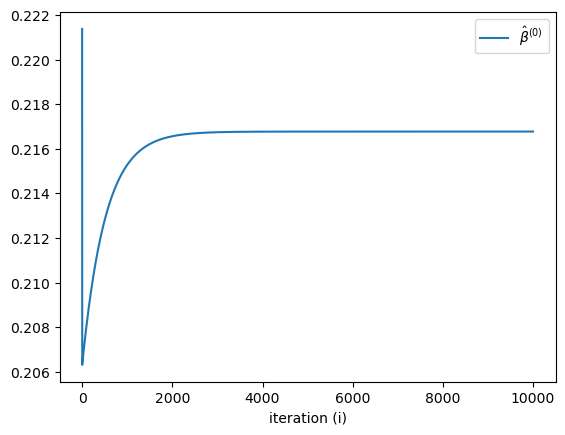

In [59]:
plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}$")
plt.xlabel("iteration (i)"); plt.legend()

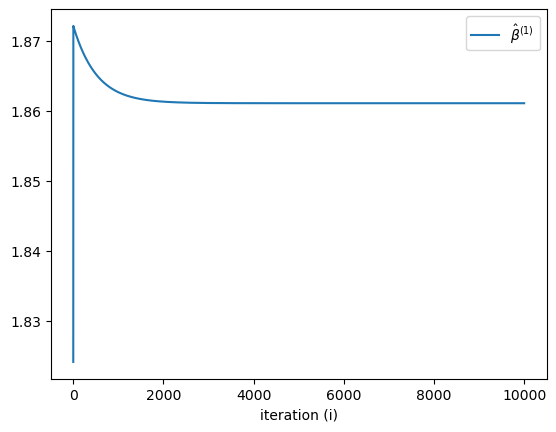

In [60]:
plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. EDA for nonparametric bootstrap

In [20]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [21]:
for t in np.arange(T+T0):
    o = np.exp(bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = - K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [22]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [23]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [24]:
Pi_inv_ImG = Pi @ inv_ImG

In [25]:
EY = (Y_data @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2) * Pi_inv_ImG[:,0]

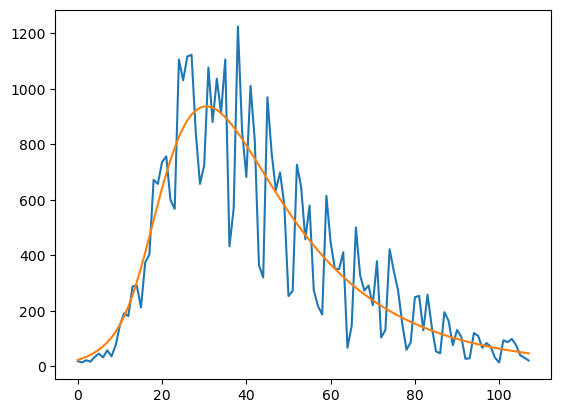

In [26]:
plt.plot(Y_data)
plt.plot(EY)

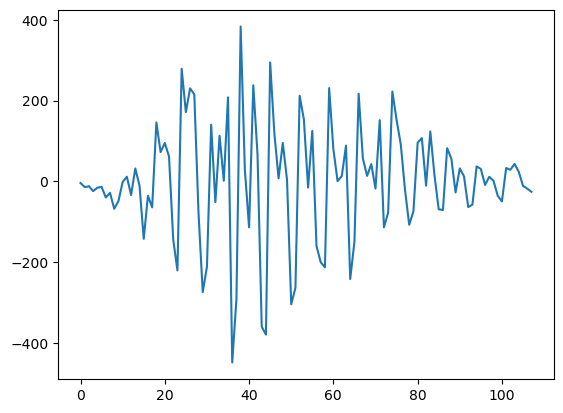

In [27]:
plt.plot(Y_data - EY)

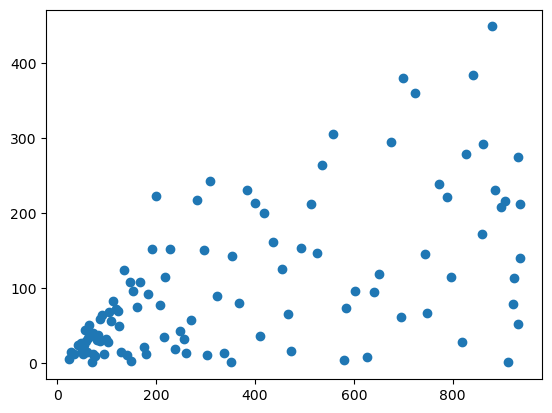

In [28]:
plt.scatter(EY, abs(Y_data-EY))

In [29]:
eps_data = (Y_data-EY)/np.sqrt(EY)

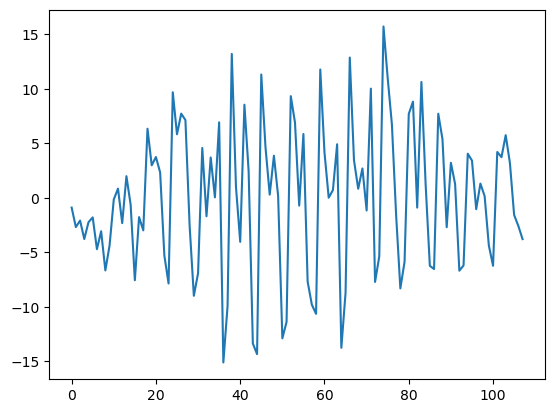

In [30]:
plt.plot(eps_data)

In [31]:
ar_order = 7
auto_eps = np.zeros(T)
for i in np.arange(ar_order+1):
    auto_eps[i] = np.mean(eps_data[i:] * eps_data[:T-i])

In [32]:
phi = la.solve(
    auto_eps[np.abs(np.arange(ar_order)[:,None] - np.arange(ar_order))],
    auto_eps[1:ar_order+1]
)

In [33]:
for i in np.arange(ar_order+1, T):
    auto_eps[i] = auto_eps[i-ar_order:i] @ phi[::-1]

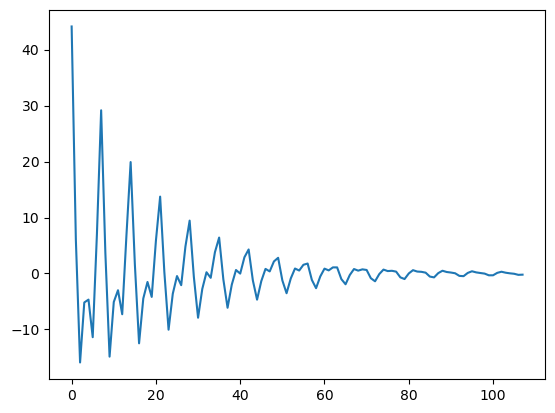

In [34]:
plt.plot(auto_eps)

In [35]:
Sigma_eps = auto_eps[np.abs(np.arange(T)[:,None] - np.arange(T))]

# 5. Nonparametric bootstrap

## simulation

In [36]:
eps_sim = np.random.multivariate_normal(np.zeros(T), Sigma_eps)

In [37]:
Y_sim = EY + np.sqrt(EY)*eps_sim

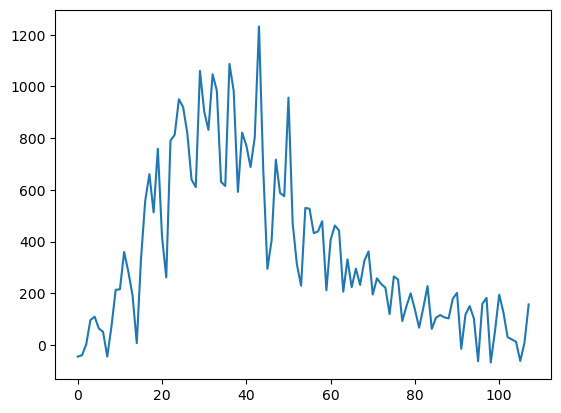

In [38]:
plt.plot(Y_sim)

In [136]:
mhat_0, shat_eps, bhat =\
    fit(Y_sim, minit_0 = mmle_0, sinit_eps = smle_eps,
        binit = bmle, history=True, n_iter=n_iter, step_size=0.05) 

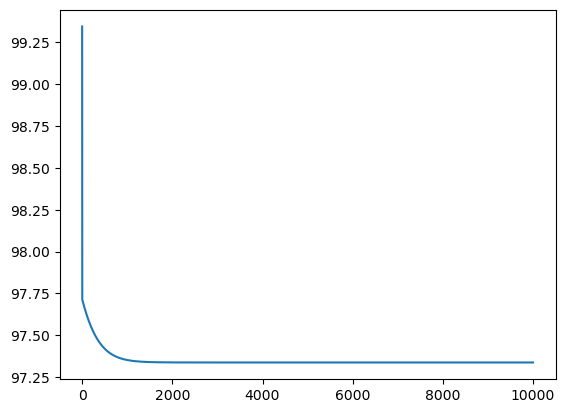

In [137]:
plt.plot(shat_eps)

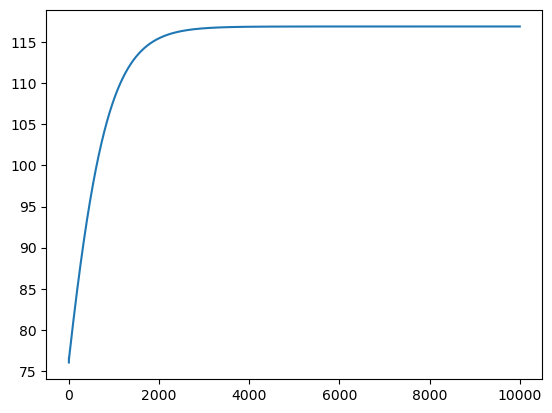

In [138]:
plt.plot(mhat_0)

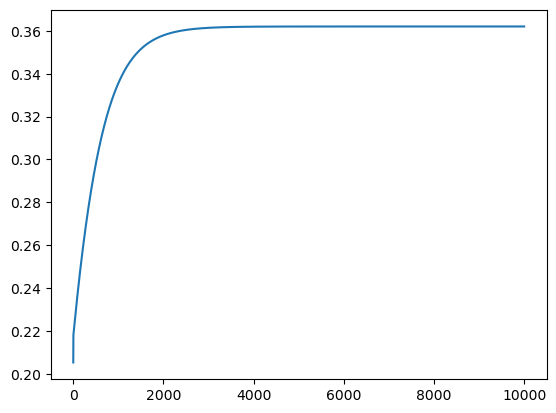

In [139]:
plt.plot(bhat[:,0])

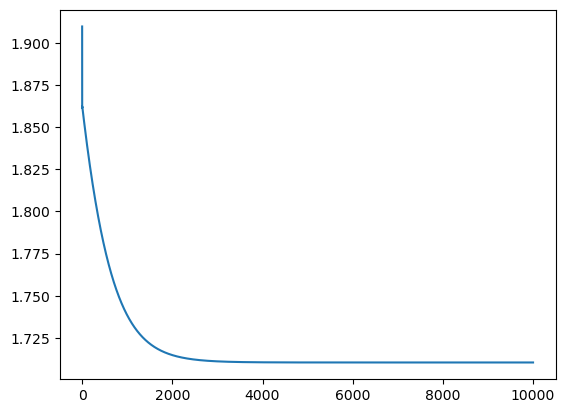

In [140]:
plt.plot(bhat[:,1])

## iteration

In [39]:
num_sim = 1000
n_iter = 10000

In [130]:
msim_0 = np.zeros([num_sim, n_iter])
ssim_eps = np.zeros([num_sim, n_iter])
bsim = np.zeros([num_sim, n_iter, d])

In [131]:
Ys_sim = np.zeros([num_sim, T])

In [141]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    eps_sim = np.random.multivariate_normal(np.zeros(T), Sigma_eps)
    Y_sim = EY + np.sqrt(EY) * eps_sim
    
    mhat_0, shat_eps, bhat =\
        fit(Y_sim, minit_0 = mmle_0, sinit_eps = smle_eps,
            binit = bmle, history=True, n_iter=n_iter, step_size=0.05) 
    
    msim_0[iter_sim] = mhat_0
    ssim_eps[iter_sim] = shat_eps
    bsim[iter_sim] = bhat
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 52.025970 sec.
2-th simulation finished, 52.136335 sec.
3-th simulation finished, 48.865131 sec.
4-th simulation finished, 49.929724 sec.
5-th simulation finished, 48.585047 sec.
6-th simulation finished, 47.508067 sec.
7-th simulation finished, 47.925553 sec.
8-th simulation finished, 47.771294 sec.
9-th simulation finished, 50.357131 sec.
10-th simulation finished, 39.844543 sec.
11-th simulation finished, 31.724339 sec.
12-th simulation finished, 32.131656 sec.
13-th simulation finished, 31.031579 sec.
14-th simulation finished, 31.153401 sec.
15-th simulation finished, 32.425602 sec.
16-th simulation finished, 31.675121 sec.
17-th simulation finished, 32.007653 sec.
18-th simulation finished, 34.250752 sec.
19-th simulation finished, 41.917367 sec.
20-th simulation finished, 42.726331 sec.
21-th simulation finished, 42.002166 sec.
22-th simulation finished, 42.371362 sec.
23-th simulation finished, 41.636001 sec.
24-th simulation finished, 39.251721 sec.
2

195-th simulation finished, 33.102441 sec.
196-th simulation finished, 32.519082 sec.
197-th simulation finished, 33.835410 sec.
198-th simulation finished, 32.890361 sec.
199-th simulation finished, 32.908113 sec.
200-th simulation finished, 33.072233 sec.
201-th simulation finished, 32.756633 sec.
202-th simulation finished, 33.229767 sec.
203-th simulation finished, 33.344124 sec.
204-th simulation finished, 32.550222 sec.
205-th simulation finished, 33.238889 sec.
206-th simulation finished, 32.827240 sec.
207-th simulation finished, 32.742260 sec.
208-th simulation finished, 33.726720 sec.
209-th simulation finished, 33.501456 sec.
210-th simulation finished, 32.543128 sec.
211-th simulation finished, 32.880409 sec.
212-th simulation finished, 33.395793 sec.
213-th simulation finished, 33.293987 sec.
214-th simulation finished, 32.658162 sec.
215-th simulation finished, 33.076533 sec.
216-th simulation finished, 32.779067 sec.
217-th simulation finished, 32.780882 sec.
218-th simu

386-th simulation finished, 32.805577 sec.
387-th simulation finished, 34.457279 sec.
388-th simulation finished, 33.948002 sec.
389-th simulation finished, 42.453043 sec.
390-th simulation finished, 40.193715 sec.
391-th simulation finished, 40.005075 sec.
392-th simulation finished, 41.546358 sec.
393-th simulation finished, 39.030482 sec.
394-th simulation finished, 39.273218 sec.
395-th simulation finished, 39.997943 sec.
396-th simulation finished, 40.605245 sec.
397-th simulation finished, 40.397847 sec.
398-th simulation finished, 40.002453 sec.
399-th simulation finished, 39.410294 sec.
400-th simulation finished, 36.442065 sec.
401-th simulation finished, 33.271906 sec.
402-th simulation finished, 33.543109 sec.
403-th simulation finished, 34.720972 sec.
404-th simulation finished, 32.714889 sec.
405-th simulation finished, 33.499351 sec.
406-th simulation finished, 32.724199 sec.
407-th simulation finished, 33.220324 sec.
408-th simulation finished, 35.310869 sec.
409-th simu

577-th simulation finished, 33.289146 sec.
578-th simulation finished, 33.702400 sec.
579-th simulation finished, 32.944851 sec.
580-th simulation finished, 32.345481 sec.
581-th simulation finished, 32.888255 sec.
582-th simulation finished, 33.057646 sec.
583-th simulation finished, 34.276917 sec.
584-th simulation finished, 32.682951 sec.
585-th simulation finished, 32.623155 sec.
586-th simulation finished, 32.709521 sec.
587-th simulation finished, 32.727518 sec.
588-th simulation finished, 33.397548 sec.
589-th simulation finished, 32.587053 sec.
590-th simulation finished, 32.531533 sec.
591-th simulation finished, 32.400745 sec.
592-th simulation finished, 33.251280 sec.
593-th simulation finished, 32.564048 sec.
594-th simulation finished, 32.696479 sec.
595-th simulation finished, 33.129874 sec.
596-th simulation finished, 32.811889 sec.
597-th simulation finished, 33.026735 sec.
598-th simulation finished, 32.630234 sec.
599-th simulation finished, 32.777671 sec.
600-th simu

768-th simulation finished, 33.278143 sec.
769-th simulation finished, 34.024446 sec.
770-th simulation finished, 32.812026 sec.
771-th simulation finished, 32.405353 sec.
772-th simulation finished, 33.451401 sec.
773-th simulation finished, 33.439517 sec.
774-th simulation finished, 33.672262 sec.
775-th simulation finished, 32.932706 sec.
776-th simulation finished, 33.150344 sec.
777-th simulation finished, 33.273900 sec.
778-th simulation finished, 32.403591 sec.
779-th simulation finished, 33.068098 sec.
780-th simulation finished, 32.567925 sec.
781-th simulation finished, 35.125547 sec.
782-th simulation finished, 32.590621 sec.
783-th simulation finished, 33.238315 sec.
784-th simulation finished, 32.438214 sec.
785-th simulation finished, 33.058684 sec.
786-th simulation finished, 33.826795 sec.
787-th simulation finished, 34.840672 sec.
788-th simulation finished, 32.318762 sec.
789-th simulation finished, 32.728995 sec.
790-th simulation finished, 33.009745 sec.
791-th simu

959-th simulation finished, 32.831455 sec.
960-th simulation finished, 33.916544 sec.
961-th simulation finished, 33.105108 sec.
962-th simulation finished, 33.005338 sec.
963-th simulation finished, 33.033733 sec.
964-th simulation finished, 33.557295 sec.
965-th simulation finished, 36.628858 sec.
966-th simulation finished, 32.790238 sec.
967-th simulation finished, 32.728419 sec.
968-th simulation finished, 32.962348 sec.
969-th simulation finished, 32.901738 sec.
970-th simulation finished, 32.546838 sec.
971-th simulation finished, 32.994118 sec.
972-th simulation finished, 33.012033 sec.
973-th simulation finished, 33.819005 sec.
974-th simulation finished, 32.802621 sec.
975-th simulation finished, 33.133100 sec.
976-th simulation finished, 32.912874 sec.
977-th simulation finished, 32.483611 sec.
978-th simulation finished, 33.739477 sec.
979-th simulation finished, 33.073771 sec.
980-th simulation finished, 32.575943 sec.
981-th simulation finished, 34.343604 sec.
982-th simu

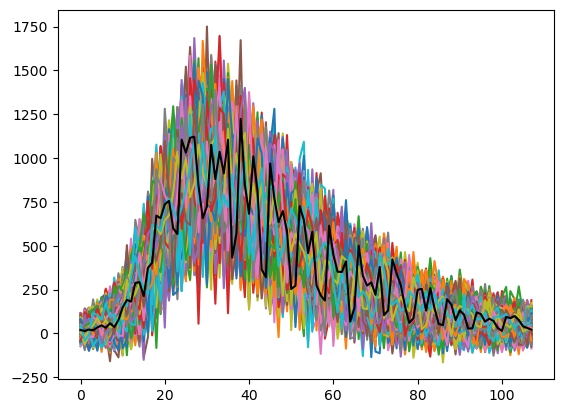

In [142]:
plt.plot(Ys_sim.T)
plt.plot(Y_data, color='black')
plt.show()

## plots

In [40]:
id_valid = (ssim_eps[:,0] - ssim_eps[:,-1] > 0)

(array([ 15., 104., 206., 243., 191., 127.,  62.,  27.,  13.,  12.]),
 array([ 76.72364944,  88.84659482, 100.96954019, 113.09248556,
        125.21543094, 137.33837631, 149.46132168, 161.58426706,
        173.70721243, 185.8301578 , 197.95310318]),
 <BarContainer object of 10 artists>)

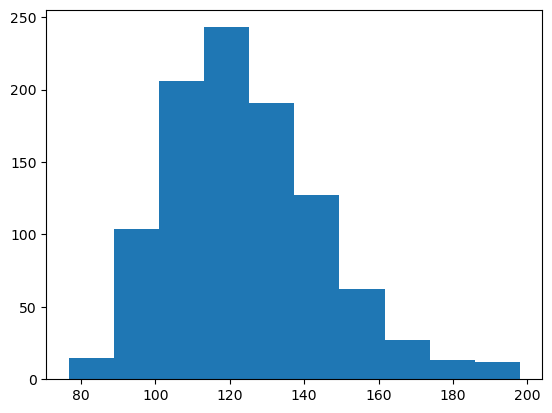

In [41]:
plt.hist(ssim_eps[id_valid,-1])

(array([ 38., 129., 220., 218., 176., 120.,  54.,  27.,  10.,   8.]),
 array([ 12.28726004,  30.91850586,  49.54975167,  68.18099749,
         86.81224331, 105.44348913, 124.07473495, 142.70598076,
        161.33722658, 179.9684724 , 198.59971822]),
 <BarContainer object of 10 artists>)

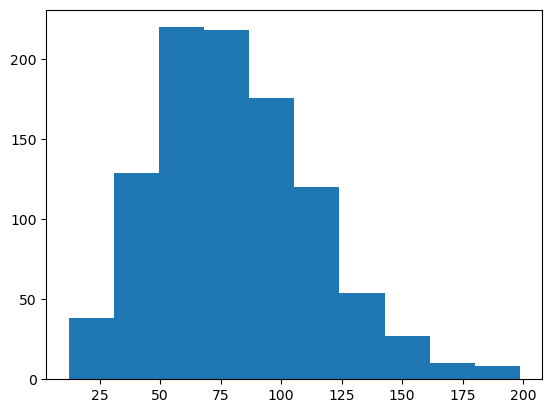

In [42]:
plt.hist(msim_0[id_valid,-1])

Text(0, 0.5, '$\\hat{\\beta}_1$')

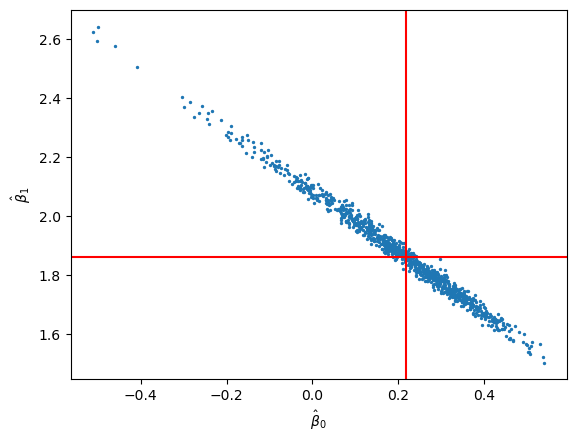

In [43]:
plt.scatter(bsim[id_valid,-1,0],bsim[id_valid,-1,1], s=2)
plt.axhline(y=bmle[1], color='red')
plt.axvline(x=bmle[0], color='red')
plt.xlabel(r"$\hat{\beta}_0$"); plt.ylabel(r"$\hat{\beta}_1$")

In [44]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[0,0])

0.15830964143882983

In [45]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[1,1])

0.16585179360868707

In [46]:
np.cov(bsim[id_valid,-1,:].T)

array([[ 0.02506194, -0.02610593],
       [-0.02610593,  0.02750682]])

In [47]:
Rsim = np.zeros([T+T0,np.sum(id_valid)])
for t in np.arange(T+T0):
    Rsim[t] = K / (1 + np.exp(bsim[id_valid,-1,:] @ A[t]))

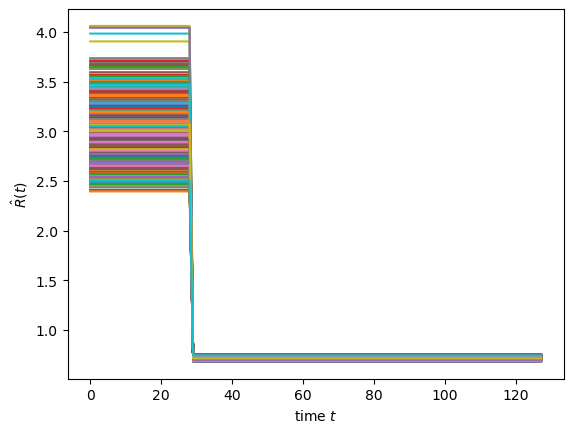

In [48]:
plt.plot(Rsim)
plt.xlabel(r"time $t$"); plt.ylabel(r"$\hat{R}(t)$")
plt.show()

# save and load

In [75]:
# np.savez("result_nonparametric_zero_s_eta.npz",
#          mmle_0 = mmle_0, smle_eps = smle_eps, bmle = bmle,
#          mhs_0 = mhs_0, shs_eps = shs_eps, bhs = bhs,
#          msim_0 = msim_0, ssim_eps = ssim_eps, bsim = bsim,
#          Ys_sim = Ys_sim, g = g, pi = pi, A = A)

In [19]:
locals().update(np.load("result_nonparametric_zero_s_eta.npz"))